In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import cv2

import functions as fn

In [3]:
dataDir='../data'
trainDir='train2017'
valDir='val2017'
seed=42
transformed=.5
train=.6
val=.2
test = 1 - train - val
strategy_list = ['left', 'right']

np.random.seed(seed)

trainAnn=f'{dataDir}/annotations/instances_{trainDir}.json'
valAnn=f'{dataDir}/annotations/instances_{valDir}.json'

cocoTrain=COCO(trainAnn)
cocoVal=COCO(valAnn)

catIdsTrain = cocoTrain.getCatIds(catNms=['person'])
imgIdsTrain = cocoTrain.getImgIds(catIds=catIdsTrain)
imgIdsTrain = cocoTrain.getImgIds(imgIds=imgIdsTrain)
annIdsTrain = cocoTrain.getAnnIds(imgIds=imgIdsTrain, catIds=catIdsTrain, iscrowd=None)

catIdsVal = cocoVal.getCatIds(catNms=['person'])
imgIdsVal = cocoVal.getImgIds(catIds=catIdsVal)
imgIdsVal = cocoVal.getImgIds(imgIds=imgIdsVal)
annIdsVal = cocoVal.getAnnIds(imgIds=imgIdsVal, catIds=catIdsVal, iscrowd=None)

loading annotations into memory...
Done (t=9.56s)
creating index...
index created!
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [7]:
count = 0
limit = 10

# 69 as control
# 42 works

#201

idx = 84

testImg = cocoTrain.loadImgs(imgIdsTrain[idx])[0]
testAnn = cocoTrain.loadAnns(cocoTrain.getAnnIds(imgIds=testImg['id'], catIds=catIdsTrain, iscrowd=None))

fpath = '{}/{}/{}'.format(dataDir, trainDir, testImg['file_name'])

testImgArr = cv2.imread(fpath)

fn.remove_true_blacks(testImgArr)

whichAnn = np.random.randint(0, len(testAnn))
#whichAnn = 1

testSpecAnn = testAnn[whichAnn] # np.random.randint(0, len(testAnn))
strategy = strategy_list[np.random.randint(0, len(strategy_list))]

print(whichAnn, strategy)

maskedTest, maskedTestInv = fn.generate_masked_images(testImgArr, testSpecAnn)

newMaskedTest = fn.apply_rolling_shutter(maskedTest, testSpecAnn, intensity=.7, strategy=strategy)

newMaskedTestInv = fn.fill_inv_masked(maskedTestInv, testSpecAnn, strategy=strategy)

recombTest = fn.recombine_masked_imgs(newMaskedTest, newMaskedTestInv)

fn.display_image(recombTest)

1 left


In [8]:
fn.display_image(testImgArr)

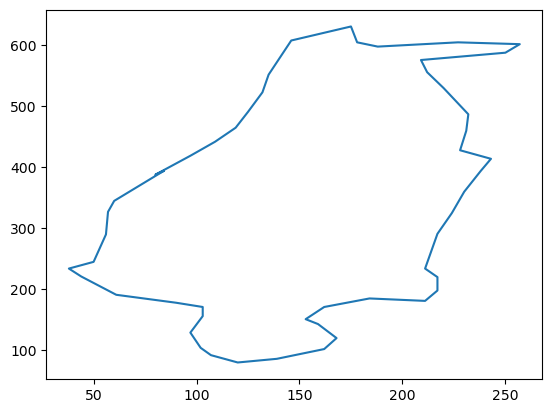

In [34]:
def coco_to_shapely(ann):
    arr = []
    temp = ann['segmentation'][0]
    for i in range(int(len(temp) / 2)):
        arr.append([temp[2 * i + 1], temp[2 * i]])
    return np.array(arr).astype(np.int32)

testPoly = Polygon(coco_to_shapely(testSpecAnn))
x, y = testPoly.exterior.xy

#print(testPoly.contains(Point(237, 306)), testPoly.contains(Point(0, 0)))

plt.plot(y, x);

In [5]:
for i in range(5):
    print(i)

for i in range(5 - 1, -1, -1):
    print(i)

0
1
2
3
4
4
3
2
1
0


In [60]:
# version 1

def apply_rolling_shutter(masked_img, ann, strategy='right', intensity=10, cutoff=.6):
    if strategy not in ['left', 'right']:
        raise ValueError(f'Strategy {strategy} is invalid')
    masked_output = np.zeros_like(masked_img)
    xmin, ymin, width, height = fn.get_ann_dims(ann)
    poly = Polygon(coco_to_shapely(ann))
    if strategy == 'right': 
        cutoff_xidx = int(((width - xmin) * cutoff) + xmin)
        for row in range(ymin, ymin + height + 1):
            for col in range(xmin, xmin + width + 1):
                if poly.contains(Point(row, col)):
                    if col < cutoff_xidx and col + intensity < masked_img.shape[1]:
                        masked_output[row, col + intensity] = masked_img[row, col]
                    else:
                        masked_output[row, col] = masked_img[row, col]
    else:
        cutoff_xidx = int(((width - xmin) * (1 - cutoff)) + xmin)
        for row in range(ymin, ymin + height + 1):
            for col in range(xmin + height, xmin - 1, -1):
                if poly.contains(Point(row, col)):
                    if col > cutoff_xidx and col - intensity >= 0:
                        masked_output[row, col - intensity] = masked_img[row, col]
                    else:
                        masked_output[row, col] = masked_img[row, col]
    return masked_output

newMaskedTestNew = apply_rolling_shutter(maskedTest, testSpecAnn, strategy='left')

fn.display_image(newMaskedTestNew)

In [81]:
# version 2 (try decay fn) -- root decay

def apply_rolling_shutter(masked_img, ann, strategy='right', intensity=.6, cutoff=.6):
    if strategy not in ['left', 'right']:
        raise ValueError(f'Strategy {strategy} is invalid')
    masked_output = np.zeros_like(masked_img)
    xmin, ymin, width, height = fn.get_ann_dims(ann)
    poly = Polygon(coco_to_shapely(ann))
    if strategy == 'right': 
        cutoff_xidx = int(((width - xmin) * cutoff) + xmin)
        for row in range(ymin, ymin + height + 1):
            for col in range(xmin, xmin + width + 1):
                if poly.contains(Point(row, col)):
                    if col < cutoff_xidx:
                        curr_intens = int(np.power(cutoff_xidx - col, intensity))
                        if col + curr_intens < masked_img.shape[1]:
                            masked_output[row, col + curr_intens] = masked_img[row, col]
                        else:
                            masked_output[row, col] = masked_img[row, col]
                    else:
                        masked_output[row, col] = masked_img[row, col]
    else:
        cutoff_xidx = int(((width - xmin) * (1 - cutoff)) + xmin)
        for row in range(ymin, ymin + height + 1):
            for col in range(xmin + height, xmin - 1, -1):
                if poly.contains(Point(row, col)):
                    if col > cutoff_xidx:
                        curr_intens = int(np.power(col - cutoff_xidx, intensity))
                        if col - curr_intens >= 0:
                            masked_output[row, col - curr_intens] = masked_img[row, col]
                        else:
                            masked_output[row, col] = masked_img[row, col]
                    else:
                        masked_output[row, col] = masked_img[row, col]
    return masked_output

newMaskedTestNew = apply_rolling_shutter(maskedTest, testSpecAnn, strategy='left')

fn.display_image(newMaskedTestNew)

In [43]:
fn.display_image(maskedTest)

In [42]:
maskedTest.shape

(640, 427, 3)

In [75]:
cutoff_idx = 400
col = 300

myThing = int(np.power(cutoff_idx - col, .5))

print(myThing, type(myThing))

10 <class 'int'>


In [ ]:
fn.get_ann_dims(testSpecAnn)

(23, 175, 254, 357)

In [ ]:
testImgArr.shape

(640, 427, 3)

In [ ]:
def fill_inv_masked(inv_masked_img, ann, strategy='right'): # when strategy='right', pull from left; when strategy='left', pull from right
    output = np.copy(inv_masked_img)

    xmin, ymin, width, height = fn.get_ann_dims(ann)
    id = ann['id']
    atLeft, atRight = False, False

    if strategy not in ['left', 'right']:
        raise ValueError(f'Strategy {strategy} is invalid')

    if xmin == 0: # at left side of image
        atLeft = True
    if xmin + width == inv_masked_img.shape[1]: # at right side of image
        atRight = True
    
    if atLeft:
        if atRight:
            raise ValueError(f'Image #{id} takes up entire image width, cannot fill')
        else:
            strategy='left'
    elif atRight:
        strategy='right'

    if strategy == 'right': # pull from left
        for row in np.arange(ymin, ymin + height):
            blacks = np.sort(np.array(list(set(np.where(output[row] == np.array([0, 0, 0]))[0]))))
            if(len(blacks) > 0):
                low = 2 * blacks[0] - 1 - blacks[-1]
                high = blacks[0]
                foo = np.flip(output[row][low:high], axis=0)
                if(low < 0):
                    foo = np.pad(np.flip(maskedTestInv[row][0:high], axis=0), ((0, -low), (0, 0)), mode='reflect')
                output[row][blacks[0]:blacks[-1] + 1] = foo
    else: # pull from right
        for row in np.arange(ymin, ymin + height):
            blacks = np.sort(np.array(list(set(np.where(output[row] == np.array([0, 0, 0]))[0]))))
            if(len(blacks) > 0):
                low = blacks[-1] + 1
                high = 2 * blacks[-1] + 2 - blacks[0] 
                foo = np.flip(output[row][low:high], axis=0)
                if(high > output.shape[1]):
                    foo = np.pad(np.flip(maskedTestInv[row][low:maskedTestInv.shape[1]], axis=0), ((0, high-maskedTestInv.shape[1]), (0, 0)), mode='reflect')
                output[row][blacks[0]:blacks[-1] + 1] = foo
    return output

newMaskedTestInv = fill_inv_masked(maskedTestInv, testSpecAnn, strategy=strategy)

final_output = fn.recombine_masked_imgs(newMaskedTest, newMaskedTestInv)

fn.display_image(final_output)

In [ ]:
fn.display_image(testImgArr)

In [ ]:
row = 265

blacks = np.sort(np.array(list(set(np.where(maskedTestInv[row] == np.array([0, 0, 0]))[0]))))
if(len(blacks) > 0):
    low = blacks[-1] + 1
    high = 2 * blacks[-1] + 2 - blacks[0] 
    foo = np.flip(maskedTestInv[row][low:high], axis=0)
    if(high > maskedTestInv.shape[1]):
        foo = np.pad(np.flip(maskedTestInv[row][low:maskedTestInv.shape[1]], axis=0), ((0, high-maskedTestInv.shape[1]), (0, 0)), mode='reflect')
        print(len(foo))

165
